In [1]:
%pylab inline
import math
import polyline
import itertools
import pandas as pd
from glob import glob
# import seaborn as sns
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans,AgglomerativeClustering
# --------------------------------------------------------
# sns.set_context('talk')
# sns.set_style('whitegrid')

def get_rawdf(test):
    rawdf = pd.read_pickle('../data/{0:s}_latest.pdpkl'.format(test))
    return rawdf

prj = 1
tests = ['inside','outin','bigpar']
N_CLUSTERS = [8,10,12][prj] # 10 for test 0
BOUNDARIES = [(250000,270000,6210000,6227000),
              (245000,275000,6205000,6235000),
              (245000,275500,6200000,6235000)][prj]
%time df = get_rawdf(tests[prj])
TITLE = tests[prj]

!mkdir plots/

Populating the interactive namespace from numpy and matplotlib
CPU times: user 2.15 s, sys: 180 ms, total: 2.33 s
Wall time: 2.97 s
mkdir: cannot create directory ‘plots/’: File exists


In [2]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
df.groupby(('mode','kind')).count()

departure  distance  duration  haversine_distance      p1  \
mode      kind                                                              
bicycling full      14819     14819     14819               14819   14819   
          step     110466    110466    110466              110466  110466   
driving   full      14819     14819     14819               14819   14819   
          step      94087     94087     94087               94087   94087   
transit   full      14819     14819     14819               14819   14819   
          step      17691     17691     17691               17691   17691   
walking   step      31644     31644     31644               31644   31644   

                    p2  polyline  walk_distance  duration[m]  distance[km]  \
mode      kind                                                               
bicycling full   14819     14819              0        14819         14819   
          step  110466         0              0       110466        110466   
driving   full   14819     14819              0        14819         14819   
          step   94087         0              0        94087         94087   
transit   full   14819     14819              0        14819         14819   
          step   17691         0              0        17691         17691   
walking   step   31644         0              0        31644         31644   

                coupled  bicycling_faster_driving    same  
mode      kind                                             
bicycling full    14819                     14819   14819  
          step   110466                    110466  110466  
driving   full    14819                     14819   14819  
          step    94087                     94087   94087  
transit   full    14819                     14819   14819  
          step    17691                     17691   17691  
walking   step    31644                     31644   31644

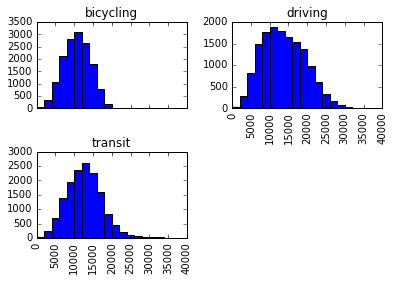

In [4]:
df[df.kind=='full'].hist(column='distance',by='mode',grid=False,sharex=1,bins=np.arange(0,40000,2000));

In [5]:
from scipy.optimize import curve_fit
def poly(x,*coeffs):
    out = 0
    for i,c in enumerate(coeffs):
        out += x**i*c
    return out

def fitit(x,y,func,p0):
    popt,pcov = curve_fit(func,p0=p0,xdata=x,ydata=y)
    ix = np.sort(x)
    return ix,poly(ix,*popt)

def wvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].var()

def mvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].mean()

def wvarlist(x,y,dx,win):
    vy = []
    my = []
    vx = []
    for x0 in np.arange(x.min(),x.max(),dx):
        xm=x0-win
        xM=x0+win
        my.append(mvar(x,y,xm,xM))
        vy.append(wvar(x,y,xm,xM))
        vx.append(x0)
    return np.asarray(vx),np.asarray(my),np.asarray(vy)
        

In [6]:
import itertools
def allclose(x,y,eps=1e-15):
    z = []
    
    for i,j in zip(x,y):
        z.append(i-j)
    try:
        for j in z:
            if abs(j)>eps:
                return False
    except TypeError:
        for j in itertools.chain.from_iterable(z):
            if abs(j)>eps:
                return False
    except:
        if abs(z)>eps: return False
    return True

In [7]:
from scipy.interpolate import interp1d
def sample_const_ds(X,Y,dx=50):
    ds = [0,]
    ds.extend((np.diff(X)**2+np.diff(Y)**2)**.5)
    L = np.cumsum(ds)
    fx = interp1d(L,X)
    fy = interp1d(L,Y)
    Lnew = np.arange(0,L.max(),dx)
    Xnew = fx(Lnew)
    Ynew = fy(Lnew)
    return Xnew,Ynew

In [8]:
import math
## http://wiki.openstreetmap.org/wiki/Mercator#Python_implementation
def _merc_x(lon):
    r_major=6378137.000
    return r_major*math.radians(lon)

def _merc_y(lat):
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

merc_x=lambda lon:np.asarray(map(_merc_x,lon))
merc_y=lambda lat:np.asarray(map(_merc_y,lat))

In [9]:
def get_coupled_trips_relative_speed(mode1,mode2,df):    
    """ compatibility function to get this stuff from the data"""
    
    # selection receipt
    cpd = df[df.coupled>0]
    row_mode1 = cpd[cpd['mode']==mode1]
    row_mode2 = cpd[cpd['mode']==mode2]
    return row_mode1,row_mode2,df

bicycling,driving,df=get_coupled_trips_relative_speed('bicycling','driving',df=df)
# idx_bike_slow = driving.bicycling_faster_driving==0
bike = bicycling[bicycling.bicycling_faster_driving==1]
car  = driving[driving.bicycling_faster_driving==0]

nobike = bicycling[bicycling.bicycling_faster_driving==0]
nocar  = driving[driving.bicycling_faster_driving==1]

In [10]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

/home/astyonax/.anaconda/lib/python2.7/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [11]:
from bokeh.tile_providers import STAMEN_TERRAIN

In [12]:
%%time
plot_width  = int(750)
plot_height = int(plot_width//1.2)
x_range, y_range = BOUNDARIES[:2],BOUNDARIES[2:]

# background = "black"
# export = partial(export_image, export_path="export", background=background)
# cm = partial(colormap_select, reverse=(background=="black"))


def base_plot(tools='pan,wheel_zoom,reset,save',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range)
#     , outline_line_color=None,
#         min_border=0, min_border_left=0, min_border_right=0,
#         min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20 µs


In [13]:
def many_points(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
    
    it = car.polyline.iteritems()
    count = 0
    path =  polyline.decode(it.next()[1])
    _X,_Y = map(None,*path)
    Y = merc_y(_X)
    X = merc_x(_Y)
    U = X/X
    _df = pd.DataFrame({'X':X,'Y':Y,'U':U})
    aggs = []
    aggs.append(cvs.line(_df,'X','Y'))

    for idx,line in it:
        path =  polyline.decode(line)
        _X = [ii[1] for ii in path]
        _Y = [ii[0] for ii in path]
        X = merc_x(_X)
        Y = merc_y(_Y)+32.2*1e3 # hacky!!
        U = X/X
        _df = pd.DataFrame({'X':X,'Y':Y,'U':U})
        aggs.append(cvs.line(_df,'X','Y'))
        count+=1
#         if count>500:break
            
    agg = aggs[0]
    for j in aggs[1:]: agg+=j
    
    img = tf.shade(agg)
    img = tf.dynspread(img, threshold=0.3, max_px=4)
    return img
# many_points()



In [14]:
p=base_plot()
p.add_tile(STAMEN_TERRAIN)
InteractiveImage(p,many_points)

In [50]:
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')

In [71]:
from bokeh.models import ColumnDataSource
import pyproj
project_projection = pyproj.Proj("+init=EPSG:4326")  # wgs84
google_projection = pyproj.Proj("+init=EPSG:3857")  # default google projection
projconv = lambda lon,lan:pyproj.transform(google_projection,project_projection,lon,lan)

In [72]:
polyline.decode?

In [102]:
count = 0
p = figure(plot_width=750,plot_height=750/2,x_range=x_range,y_range=y_range)
p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
for idx,line in tqdm(bike.polyline.iteritems()):
    path =  polyline.decode(line,5)
    _X = [ii[1] for ii in path]
    _Y = [ii[0] for ii in path]
    X = merc_x(_X)
    Y = merc_y(_Y)+32.2*1e3 # hacky!!
    p.line(x=X,y=Y)
    count += 1
    
    if count>100:break
p.add_tile(STAMEN_TONER)
show(p)


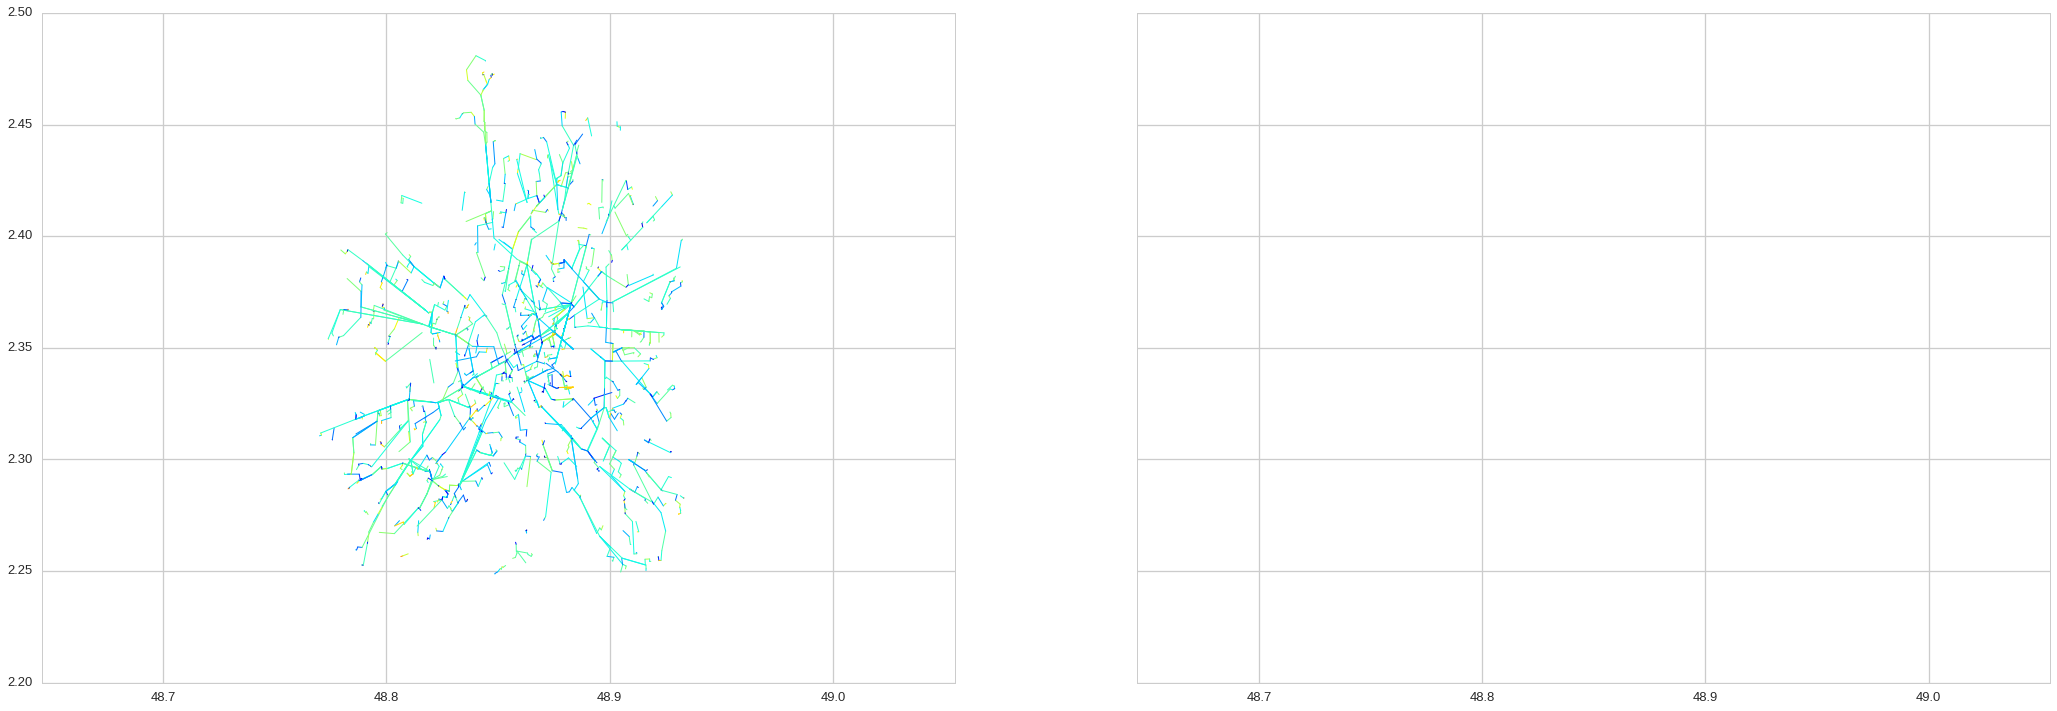

In [141]:
from itertools import cycle
fig,axs=plt.subplots(1,2,sharex='all',sharey='all',figsize=(12*3,4*3))
ms = cycle(['-','--'])
chepalle = []
Xs=[]
Ys=[]
for i in xrange(0,200):
    for dati,ax in zip((bike,),axs):
        bg,ed=dati.index[i:i+2]
        # df.duration.iat[range(bg,ed)]
    
        if df.kind.iat[bg]!='full':break
        for j in xrange(bg+1,ed):
            if (df.kind.iat[j]=='full'):break
            T  = df.duration.iat[j]
            D  = df.distance.iat[j]*1.
            p1 = df.p1.iat[j]
            p2 = df.p2.iat[j]
            path = [p1,p2]
            _X,_Y = map(None,*path)
#             Y = merc_y(_X)
#             X = merc_x(_Y)
            Xs.append(_X)
            Ys.append(_Y)
            chepalle.append(D/T)
for x,y,cr in zip(Xs,Ys,plt.Normalize()(chepalle)):
    ax.plot(x,y,'-',color=plt.cm.jet(cr),lw=1)
#         print np.max(chepalle)
#         plt.plot(np.cumsum(chepalle),ms.next())
        
ax.set_aspect('equal')